In [1]:
# Imports

In [2]:
%%time
#Imports requisite packages
import os
import time
import numpy
import pickle
import cProfile
import itertools
import matplotlib
import sklearn.tree
import sklearn.metrics
import sklearn.ensemble
import sklearn.preprocessing
import sklearn.learning_curve
import sklearn.model_selection
import sklearn.cross_validation
import sklearn.feature_selection
import sklearn.kernel_approximation
from matplotlib import pyplot as plt
from sklearn.cross_validation import *
from sklearn.metrics import *
from sklearn.feature_selection import *
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.model_selection import *


#%jsroot on9
%matplotlib inline
matplotlib.use('Agg')

/usr/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


CPU times: user 885 ms, sys: 148 ms, total: 1.03 s
Wall time: 1.37 s


/usr/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Function Definitions

In [3]:
%%time
#Takes the converted tree and turns it into an
#n-by-30 array usable by sklearn.
def outputs(array):
    #Only uses events with non-zero luminosity
    goodEvents = array[array['lumi'] != 0]
    ind = numpy.lexsort((goodEvents['lumiId'],goodEvents['runId']))
    events = goodEvents[ind]
    dataset = numpy.empty([len(goodEvents),30])
    target = numpy.empty([len(goodEvents)])
    badOnes = numpy.array([])

    #Fills dataset array with proper features
    for j, event in enumerate(events):
        try:
            dataset[j,0:7] = event['qPFJetPt']
            dataset[j,7:14] = event['qPFJetEta']
            dataset[j,14:21] = event['qPFJetPhi']
            dataset[j,21:28] = event['qNVtx']
            dataset[j,28] = event['crossSection']
            dataset[j,29] = event['lumi']
            target[j] = event['isSig']
        except ValueError:
            badOnes = numpy.append(badOnes,j)
            
    #Takes out corrupt events
    mask = numpy.zeros(len(dataset), dtype=bool)
    mask[badOnes.astype(int)] = True
    mask = ~mask
    dataset = dataset[mask]
    target = target[mask]
       
    return dataset, target

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 6.2 µs


In [4]:
#Function that plots confusion matrix, taken from sklearn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    #This function prints and plots the confusion matrix.
    #Normalization can be applied by setting `normalize=True`.     
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = numpy.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        print("Normalized confusion matrix")
    else:
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = numpy.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        print('Confusion matrix, without normalization')

    print(cm)
    
    thresh = cm.max()*.7
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Prep

In [5]:
#Loads pickled dataset
inFile = open('realData.pkl', 'rb')
dataset = pickle.load(inFile, encoding="latin1")
target = pickle.load(inFile, encoding="latin1")
inFile.close()

In [6]:
lumi = dataset[:,-1]
dataset = dataset[:,:-1]
sigInd = numpy.where(target==1)
backInd = numpy.where(target==0)
sigVals = dataset[sigInd]
backVals = dataset[backInd]
sigTarget = target[sigInd]
backTarget = target[backInd]

sigTrain, sigTest, sigTrainTarget, sigTestTarget = train_test_split(sigVals, sigTarget, test_size=.2)


In [7]:
# #Imports training and testing sets used across models
# inFile = open('splits.pkl', 'rb')
# xTrain = pickle.load(inFile, encoding="latin1")
# xTest = pickle.load(inFile, encoding="latin1")
# yTrain = pickle.load(inFile, encoding="latin1")
# yTest = pickle.load(inFile, encoding="latin1")
# lumiTrain = pickle.load(inFile, encoding="latin1")
# lumiTest = pickle.load(inFile, encoding="latin1")
# inFile.close()

In [8]:
#Removes features with variance less than 0.1
# sel = VarianceThreshold(threshold = 0.01)
# print(sigTrain.shape)
# sel.fit(sigTrain)
# indices = sel.get_support()
# sigTrain = sigTrain[:,indices]
# print(sigTrain.shape)
# sigTest = sigTest[:,indices]
# print(indices)
# backVals = backVals[:,indices]

In [9]:
#Scales the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(sigTrain)
sigTrain = scaler.transform(sigTrain)
sigTest = scaler.transform(sigTest)
backVals = scaler.transform(backVals)
backTarget[backTarget == 0] = -1

xTest=numpy.concatenate([sigTest, backVals])
print(xTest)
yTest=numpy.concatenate([sigTestTarget, backTarget])
print(yTest)
# sigTrainTarget[sigTrainTarget == 0] = -1
# sigTestTarget[sigTestTarget == 0] = -1
# print(len(sigTestTarget[sigTestTarget==-1]))
# print(len(sigTrainTarget[sigTrainTarget==1]))

[[-0.2624805  -0.00836714 -0.02903535 ...,  1.26030093  1.23090154
  -0.4323365 ]
 [ 0.86598709 -0.20846535 -0.0769658  ..., -1.61694802 -1.19356479
   0.4699908 ]
 [-1.68651531 -0.21990819 -0.08957908 ...,  1.67133649  1.74518228
  -0.37580992]
 ..., 
 [ 0.49753054  0.00476078  0.04714885 ..., -0.7948769  -0.89969009
  -0.03797998]
 [ 0.40510299  0.04024267  0.09205211 ..., -0.7948769  -0.89969009
  -0.01007285]
 [ 0.40016589 -0.0322895  -0.02373777 ..., -0.7948769  -0.75275273
  -0.08765461]]
[ 1.  1.  1. ..., -1. -1. -1.]


In [10]:

#Grid Search with cross validation

# tunedParams = [{'nu': [0.1, 0.4, 0.7, 0.9], 'gamma': ["auto", 0.1, 0.005, 0.5]}]
# scores = ['precision', 'recall']
# for score in scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()
    
#     clf = GridSearchCV(OneClassSVM(shrinking = True), tunedParams, scoring='%s' % score, n_jobs=-1)
#     clf.fit(sigTrain, sigTrainTarget)

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     means = clf.cv_results_['mean_test_score']
#     stds = clf.cv_results_['std_test_score']
#     for mean, std, params in zip(means, stds, clf.cv_results_['params']):
#         print("%0.3f (+/-%0.03f) for %r"
#               % (mean, std * 2, params))
#     print()

#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = yTest, clf.predict(xTest)
#     print(classification_report(y_true, y_pred))
#     print()

In [11]:
%%time
osvmClf = OneClassSVM(nu=0.05, kernel="rbf", verbose=True)
osvmClf.fit(sigTrain)


[LibSVM]CPU times: user 20min 33s, sys: 1.24 s, total: 20min 34s
Wall time: 20min 39s


In [12]:
y_pred_train = osvmClf.predict(sigTrain)
y_pred_test = osvmClf.predict(sigTest)
y_pred_outliers = osvmClf.predict(backVals)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

In [13]:
print("Number of errors on training set: ", n_error_train, " Percentage: ", (n_error_train/len(sigTrain)*100))
print("Number of errors on test set: ", n_error_test, " Percentage: ", (n_error_test/len(sigTest)*100))
print("Number of errors on outliers set: ", n_error_outliers, " Percentage: ", (n_error_outliers/len(backVals)*100))

Number of errors on training set:  8820  Percentage:  5.001360914534567
Number of errors on test set:  2227  Percentage:  5.051146544489555
Number of errors on outliers set:  3327  Percentage:  27.731932983245812


In [14]:
# %%time

# #Provides classification reports 
# osvmScore = osvmClf.fit(sigTrain).decision_function(sigTest)
    
# osvmPredict = osvmClf.predict(sigTest)
# print("Classification report for osvm, Tuned, Weights %s:\n%s\n"
#       % (osvmClf, sklearn.metrics.classification_report(sigTestTarget, osvmPredict)))

In [15]:
# %%time
#Plots classification results for signal and background
osvmArrs = []
osvmHists = []

#Separates decision function results into signal and background
#along with training and testing
osvmArrs.append(osvmClf.decision_function(sigTrain).ravel())
osvmArrs.append(osvmClf.decision_function(sigTest).ravel())
osvmArrs.append(osvmClf.decision_function(backVals).ravel())
print(len(osvmArrs[0]))
print(len(osvmArrs[1]))
print(len(osvmArrs[2]))

176352
44089
11997


In [16]:
#Turns those arrays into histograms
osvmHists.append(list(numpy.histogram(osvmArrs[0], normed = True, bins = 40)))
osvmHists.append(list(numpy.histogram(osvmArrs[1], normed = True, bins = 40)))
osvmHists.append(list(numpy.histogram(osvmArrs[2], normed = True, bins = 40)))

#Defines bin edges, centers, and widths
osvmMax = max([max(hist[0]) for hist in osvmHists])*1.2
osvmMin = max([min(hist[0]) for hist in osvmHists])
osvmEdges1 = osvmHists[0][1]
osvmCenters1 = (osvmEdges1[:-1] + osvmEdges1[1:])/2.
osvmWidths1 = (osvmEdges1[1:] - osvmEdges1[:-1])
osvmEdges2 = osvmHists[1][1]
osvmCenters2 = (osvmEdges2[:-1] + osvmEdges2[1:])/2.
osvmWidths2 = (osvmEdges2[1:] - osvmEdges2[:-1])
osvmEdges3 = osvmHists[2][1]
osvmCenters3 = (osvmEdges3[:-1] + osvmEdges3[1:])/2.
osvmWidths3 = (osvmEdges3[1:] - osvmEdges3[:-1])

In [17]:
#Normalizes histogram based on maximum value
osvmNormVal1 = max(max(osvmHists[0][0]), max(osvmHists[1][0]), max(osvmHists[2][0]))
osvmHists[0][0] = [x/osvmNormVal1 for x in osvmHists[0][0]]
osvmHists[1][0] = [x/osvmNormVal1 for x in osvmHists[1][0]]
osvmHists[2][0] = [x/osvmNormVal1 for x in osvmHists[2][0]]

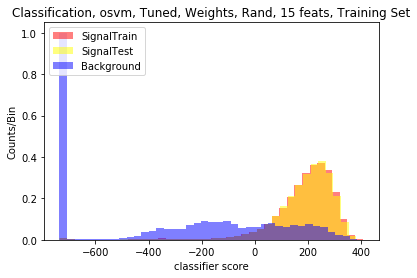

CPU times: user 901 ms, sys: 44.4 ms, total: 945 ms
Wall time: 952 ms


In [18]:
%%time
#Plots histograms
ax1 = plt.subplot(111)
ax1.bar(osvmCenters1-osvmWidths1/2.,osvmHists[0][0],facecolor='red',linewidth=0,width=osvmWidths1,label='SignalTrain',alpha=0.5)
ax1.bar(osvmCenters2-osvmWidths2/2.,osvmHists[1][0],facecolor='yellow',linewidth=0,width=osvmWidths2,label='SignalTest',alpha=0.5)
ax1.bar(osvmCenters3-osvmWidths3/2.,osvmHists[2][0],facecolor='blue',linewidth=0,width=osvmWidths3,label='Background',alpha=0.5)
#Change depending on which classifier and options are chosen
plt.title("Classification, osvm, Tuned, Weights, Rand, 15 feats, Training Set")
plt.xlabel("classifier score")
plt.ylabel("Counts/Bin")
legend = ax1.legend(loc='upper center', shadow=True,ncol=3)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')
plt.legend(loc='upper left')
plt.show()

# ax2 = plt.subplot(111)
# ax2.bar(osvmCenters-osvmWidths/2.,osvmHists[2][0],facecolor='red',linewidth=0,width=osvmWidths,label='Signal',alpha=0.5)
# ax2.bar(osvmCenters-osvmWidths/2.,osvmHists[3][0],facecolor='blue',linewidth=0,width=osvmWidths,label='Background',alpha=0.5)
# plt.title("Classification, osvm, Tuned, Weights, Rand, 15 feats, Testing Set")
# plt.xlabel("classifier score")
# plt.ylabel("Counts/Bin")
# legend = ax1.legend(loc='upper center', shadow=True,ncol=2)
# for alabel in legend.get_texts():
#             alabel.set_fontsize('small')
# plt.legend(loc='upper left')
# plt.show()

In [19]:

# %%time
#Plots classification results for signal and background
trainArrs = []
testArrs = []
backArrs = []
trainHists = []
testHists = []
backHists = []

#Separates decision function results into signal and background
#along with training and testing
trainArrs.append(osvmClf.decision_function(sigTrain[y_pred_train == 1]).ravel())
trainArrs.append(osvmClf.decision_function(sigTrain[y_pred_train == -1]).ravel())
testArrs.append(osvmClf.decision_function(sigTest[y_pred_test == 1]).ravel())
testArrs.append(osvmClf.decision_function(sigTest[y_pred_test == -1]).ravel())
backArrs.append(osvmClf.decision_function(backVals[y_pred_outliers == -1]).ravel())
backArrs.append(osvmClf.decision_function(backVals[y_pred_outliers == 1]).ravel())

#Turns those arrays into histograms
trainHists.append(list(numpy.histogram(trainArrs[0], normed = True, bins = 40)))
trainHists.append(list(numpy.histogram(trainArrs[1], normed = True, bins = 40)))
testHists.append(list(numpy.histogram(testArrs[0], normed = True, bins = 40)))
testHists.append(list(numpy.histogram(testArrs[1], normed = True, bins = 40)))
backHists.append(list(numpy.histogram(backArrs[0], normed = True, bins = 40)))
backHists.append(list(numpy.histogram(backArrs[1], normed = True, bins = 40)))

#Defines bin edges, centers, and widths
trainMax = max([hist[0].max() for hist in trainHists])*1.2
trainMin = max([hist[0].min() for hist in trainHists])
trainEdges = trainHists[0][1]
trainCenters = (trainEdges[:-1] + trainEdges[1:])/2.
trainWidths = (trainEdges[1:] - trainEdges[:-1])

testMax = max([hist[0].max() for hist in testHists])*1.2
testMin = max([hist[0].min() for hist in testHists])
testEdges = testHists[0][1]
testCenters = (testEdges[:-1] + testEdges[1:])/2.
testWidths = (testEdges[1:] - testEdges[:-1])

backMax = max([hist[0].max() for hist in backHists])*1.2
backMin = max([hist[0].min() for hist in backHists])
backEdges = backHists[0][1]
backCenters = (backEdges[:-1] + backEdges[1:])/2.
backWidths = (backEdges[1:] - backEdges[:-1])

(array([  86.,  108.,   78.,  102.,  116.,  115.,  122.,  105.,  131.,
         113.,   95.,  103.,   84.,  112.,   82.,  101.,  101.,  114.,
          84.,  120.,  110.,  117.,  116.,   96.,   98.,  107.,  102.,
          92.,   71.,   70.,   52.,   50.,   30.,   30.,   35.,   26.,
          23.,   13.,   10.,    7.]),
 array([  4.15334954e-02,   1.00105355e+01,   1.99795375e+01,
          2.99485395e+01,   3.99175416e+01,   4.98865436e+01,
          5.98555456e+01,   6.98245476e+01,   7.97935496e+01,
          8.97625516e+01,   9.97315537e+01,   1.09700556e+02,
          1.19669558e+02,   1.29638560e+02,   1.39607562e+02,
          1.49576564e+02,   1.59545566e+02,   1.69514568e+02,
          1.79483570e+02,   1.89452572e+02,   1.99421574e+02,
          2.09390576e+02,   2.19359578e+02,   2.29328580e+02,
          2.39297582e+02,   2.49266584e+02,   2.59235586e+02,
          2.69204588e+02,   2.79173590e+02,   2.89142592e+02,
          2.99111594e+02,   3.09080596e+02,   3.19049598e+

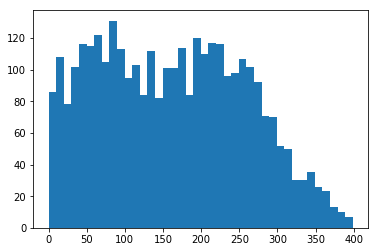

In [20]:

#Normalizes histogram based on maximum value
trainNormVal1 = max(max(trainHists[0][0]), max(trainHists[1][0]))
trainHists[0][0] = [x/trainNormVal1 for x in trainHists[0][0]]
trainHists[1][0] = [x/trainNormVal1 for x in trainHists[1][0]]
testNormVal1 = max(max(testHists[0][0]), max(testHists[1][0]))
testHists[0][0] = [x/testNormVal1 for x in testHists[0][0]]
testHists[1][0] = [x/testNormVal1 for x in testHists[1][0]]
backNormVal1 = max(max(backHists[0][0]), max(backHists[1][0]))
backHists[0][0] = [x/backNormVal1 for x in backHists[0][0]]
backHists[1][0] = [x/backNormVal1 for x in backHists[1][0]]
plt.hist(backArrs[1],40)

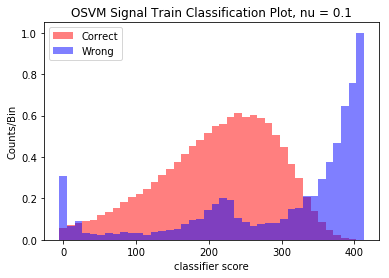

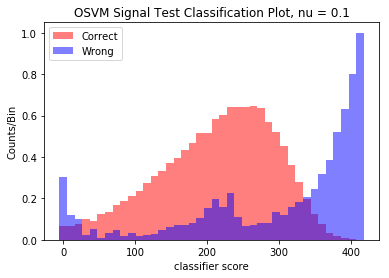

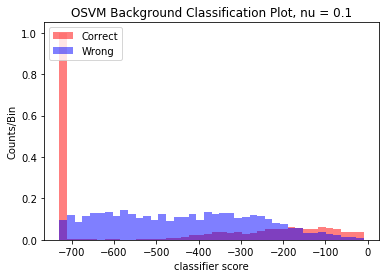

CPU times: user 1.43 s, sys: 93.9 ms, total: 1.53 s
Wall time: 1.57 s


In [21]:

%%time
fig = plt.figure()
#Plots histograms
ax1 = plt.subplot(111)
ax1.bar(trainCenters-trainWidths/2.,trainHists[0][0],facecolor='red',linewidth=0,width=trainWidths,label='Correct',alpha=0.5)
ax1.bar(trainCenters-trainWidths/2.,trainHists[1][0],facecolor='blue',linewidth=0,width=trainWidths,label='Wrong',alpha=0.5)
#Change depending on which classifier and options are chosen
plt.title("OSVM Signal Train Classification Plot, nu = 0.1")
plt.xlabel("classifier score")
plt.ylabel("Counts/Bin")
legend = ax1.legend(loc='upper center', shadow=True,ncol=3)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')
plt.legend(loc='upper left')
plt.show()

ax2 = plt.subplot(111)
ax2.bar(testCenters-testWidths/2.,testHists[0][0],facecolor='red',linewidth=0,width=testWidths,label='Correct',alpha=0.5)
ax2.bar(testCenters-testWidths/2.,testHists[1][0],facecolor='blue',linewidth=0,width=testWidths,label='Wrong',alpha=0.5)
#Change depending on which classifier and options are chosen
plt.title("OSVM Signal Test Classification Plot, nu = 0.1")
plt.xlabel("classifier score")
plt.ylabel("Counts/Bin")
legend = ax2.legend(loc='upper center', shadow=True,ncol=3)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')
plt.legend(loc='upper left')
plt.show()

ax3 = plt.subplot(111)
ax3.bar(backCenters-backWidths/2.,backHists[0][0],facecolor='red',linewidth=0,width=backWidths,label='Correct',alpha=0.5)
ax3.bar(backCenters-backWidths/2.,backHists[1][0],facecolor='blue',linewidth=0,width=backWidths,label='Wrong',alpha=0.5)
#Change depending on which classifier and options are chosen
plt.title("OSVM Background Classification Plot, nu = 0.1")
plt.xlabel("classifier score")
plt.ylabel("Counts/Bin")
legend = ax3.legend(loc='upper center', shadow=True,ncol=3)
for alabel in legend.get_texts():
            alabel.set_fontsize('small')
plt.legend(loc='upper left')
plt.show()
plt.savefig("nu_0.1_three.pdf")
